<a href="https://colab.research.google.com/github/millandmills/homework/blob/main/Homework_1_PCA_KNN_Me%D1%85%D1%82%D0%B8%D0%B5%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Train shape: (55000, 784)
Labels shape: (55000,)


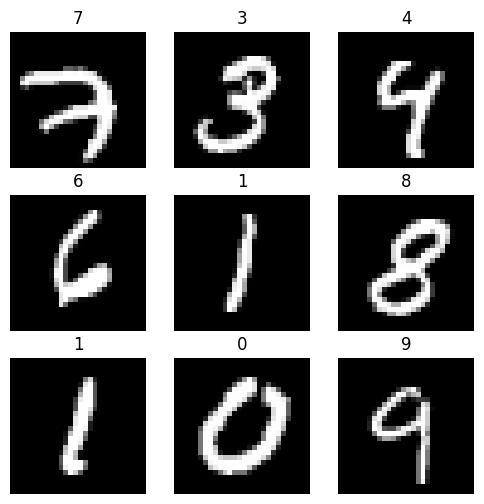

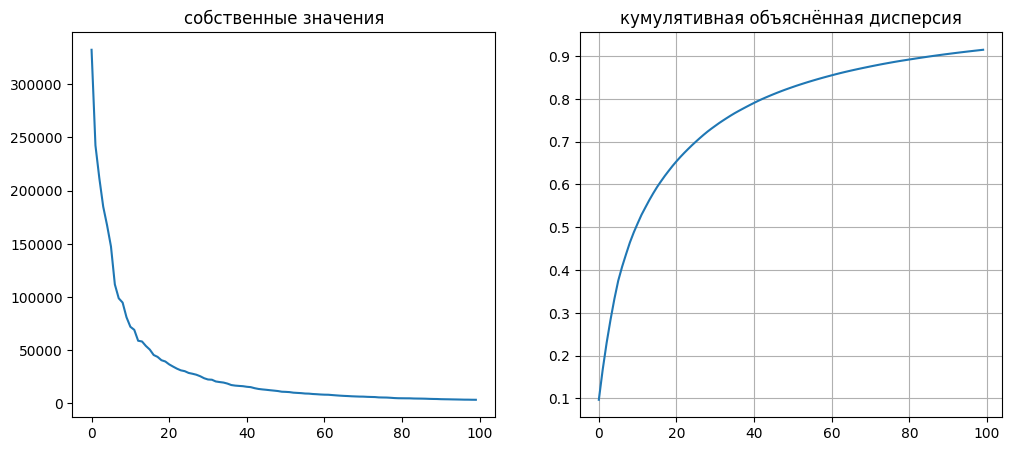

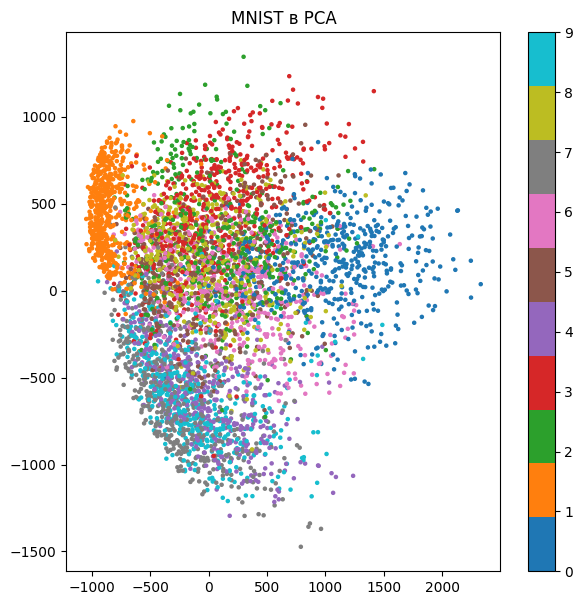

точность без PCA: 0.924
точность с PCA (по 40): 0.937
PCA=5, k=1, точность=0.6690
PCA=5, k=3, точность=0.6850
PCA=5, k=5, точность=0.7030
PCA=5, k=7, точность=0.7180
PCA=5, k=10, точность=0.7300
PCA=5, k=15, точность=0.7330
PCA=10, k=1, точность=0.8740
PCA=10, k=3, точность=0.8860
PCA=10, k=5, точность=0.8840
PCA=10, k=7, точность=0.8840
PCA=10, k=10, точность=0.8780
PCA=10, k=15, точность=0.8680
PCA=20, k=1, точность=0.9350
PCA=20, k=3, точность=0.9280
PCA=20, k=5, точность=0.9280
PCA=20, k=7, точность=0.9310
PCA=20, k=10, точность=0.9270
PCA=20, k=15, точность=0.9280
PCA=30, k=1, точность=0.9340
PCA=30, k=3, точность=0.9370
PCA=30, k=5, точность=0.9350
PCA=30, k=7, точность=0.9320
PCA=30, k=10, точность=0.9340
PCA=30, k=15, точность=0.9290
PCA=40, k=1, точность=0.9300
PCA=40, k=3, точность=0.9290
PCA=40, k=5, точность=0.9370
PCA=40, k=7, точность=0.9340
PCA=40, k=10, точность=0.9270
PCA=40, k=15, точность=0.9250
PCA=50, k=1, точность=0.9280
PCA=50, k=3, точность=0.9280
PCA=50, k=5, т

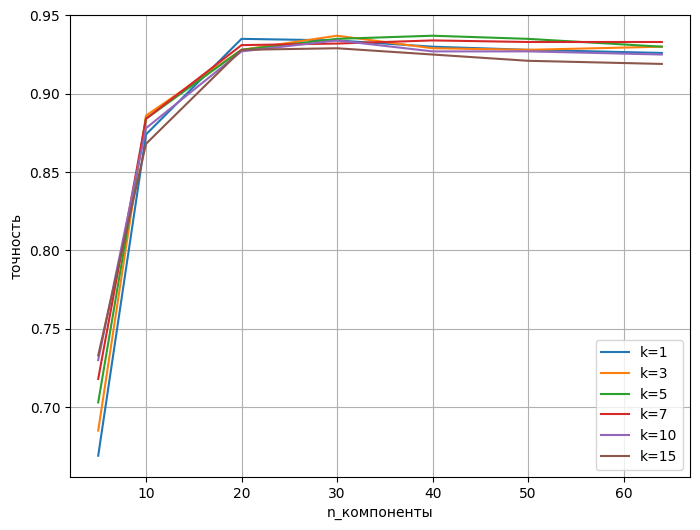

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mnist import load_mnist

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_mnist()

X = train_images.reshape(len(train_images), -1).astype(np.float32)
y = train_labels

print("Train shape:", X.shape)
print("Labels shape:", y.shape)

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i].reshape(28,28), cmap="gray")
    plt.title(int(train_labels[i]))
    plt.axis("off")
plt.show()

class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigvals = None

    def fit(self, X):
        self.mean = X.mean(axis=0)
        Xc = X - self.mean

        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

        self.components = Vt[:self.n_components]
        self.eigvals = (S**2) / (X.shape[0] - 1)

        return self

    def transform(self, X):
        Xc = X - self.mean
        return np.dot(Xc, self.components.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

pca_full = my_PCA(n_components=200)
pca_full.fit(X)

eigvals = pca_full.eigvals
cum = np.cumsum(eigvals) / np.sum(eigvals)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eigvals[:100])
plt.title("собственные значения")

plt.subplot(1,2,2)
plt.plot(cum[:100])
plt.title("кумулятивная объяснённая дисперсия")
plt.grid()
plt.show()

pca2 = my_PCA(n_components=2)
X2 = pca2.fit_transform(X)

plt.figure(figsize=(7,7))
plt.scatter(X2[:5000,0], X2[:5000,1], c=y[:5000], cmap="tab10", s=5)
plt.colorbar()
plt.title("MNIST в PCA")
plt.show()

class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        preds = []
        for x in X:
            dist = np.linalg.norm(self.X - x, axis=1)
            idx = np.argsort(dist)[:self.n_neighbors]
            vals, counts = np.unique(self.y[idx], return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#KNN без PCA
knn = my_kNN(n_neighbors=5)
knn.fit(X_train[:5000], y_train[:5000])   # reduced for speed

y_pred = knn.predict(X_test[:1000])
acc_no_pca = accuracy_score(y_test[:1000], y_pred)
print("точность без PCA:", acc_no_pca)

#KNN + PCA

pca = my_PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn = my_kNN(n_neighbors=5)
knn.fit(X_train_pca[:5000], y_train[:5000])

y_pred = knn.predict(X_test_pca[:1000])
acc_with_pca = accuracy_score(y_test[:1000], y_pred)

print("точность с PCA (по 40):", acc_with_pca)

components_list = [5, 10, 20, 30, 40, 50, 64]
neighbors_list = [1, 3, 5, 7, 10, 15]

results = {}

for n_comp in components_list:
    pca = my_PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for k in neighbors_list:
        knn = my_kNN(n_neighbors=k)
        knn.fit(X_train_pca[:5000], y_train[:5000])
        y_pred = knn.predict(X_test_pca[:1000])
        acc = accuracy_score(y_test[:1000], y_pred)

        results[(n_comp, k)] = acc
        print(f"PCA={n_comp}, k={k}, точность={acc:.4f}")


plt.figure(figsize=(8,6))
for k in neighbors_list:
    vals = [results[(c, k)] for c in components_list]
    plt.plot(components_list, vals, label=f"k={k}")

plt.xlabel("n_компоненты")
plt.ylabel("точность")
plt.legend()
plt.grid()
plt.show()